In [1]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import time

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

***
# Vanilla LSTM with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.031] 0.0


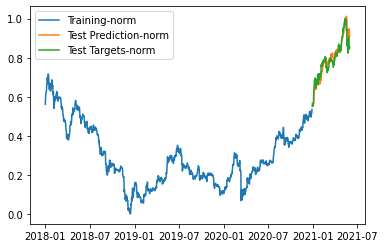

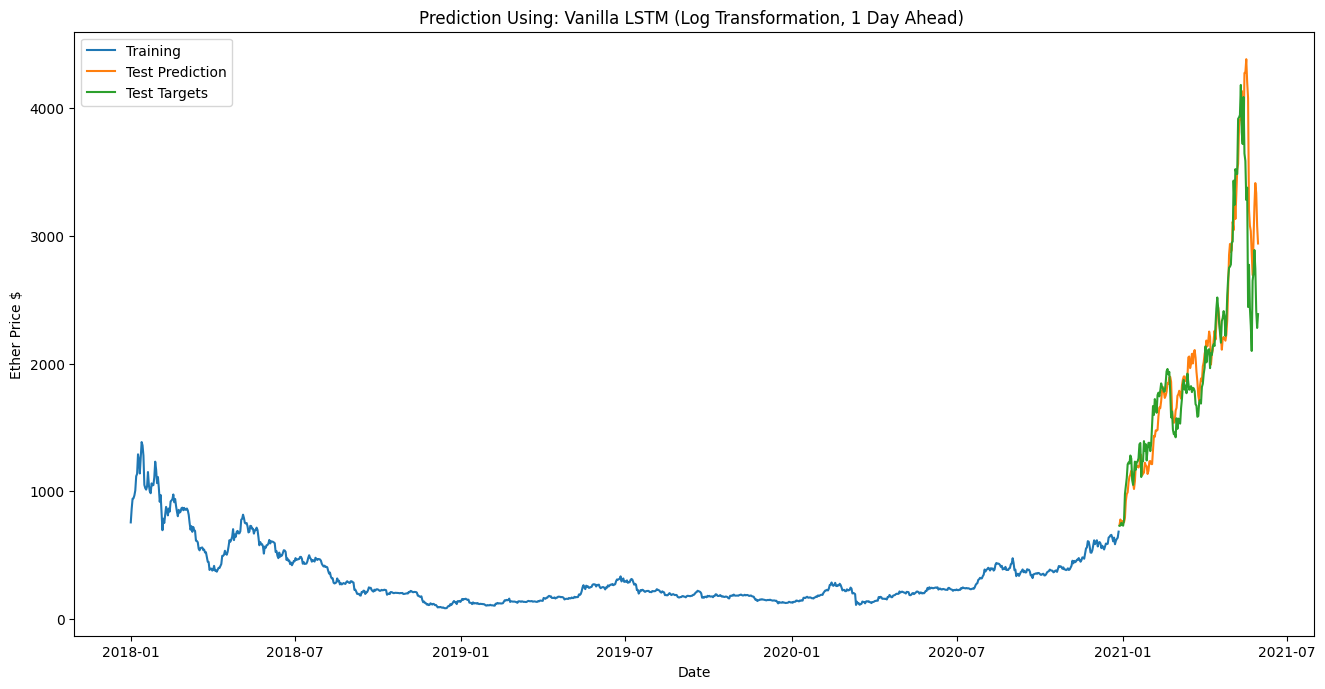

Total RMSE is:  293.9240662245284
Total APE is:  9.498927602779919
Runtime of the program is 34.97164297103882


In [9]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

n_features = train_x.shape[2]

# separate input data
#X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
#Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_x, train_y, epochs=200, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_input, n_features))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='LSTM')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Vanilla LSTM (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# Stacked LSTM with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.048] 0.0


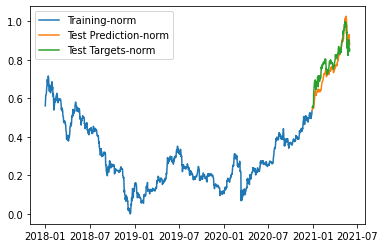

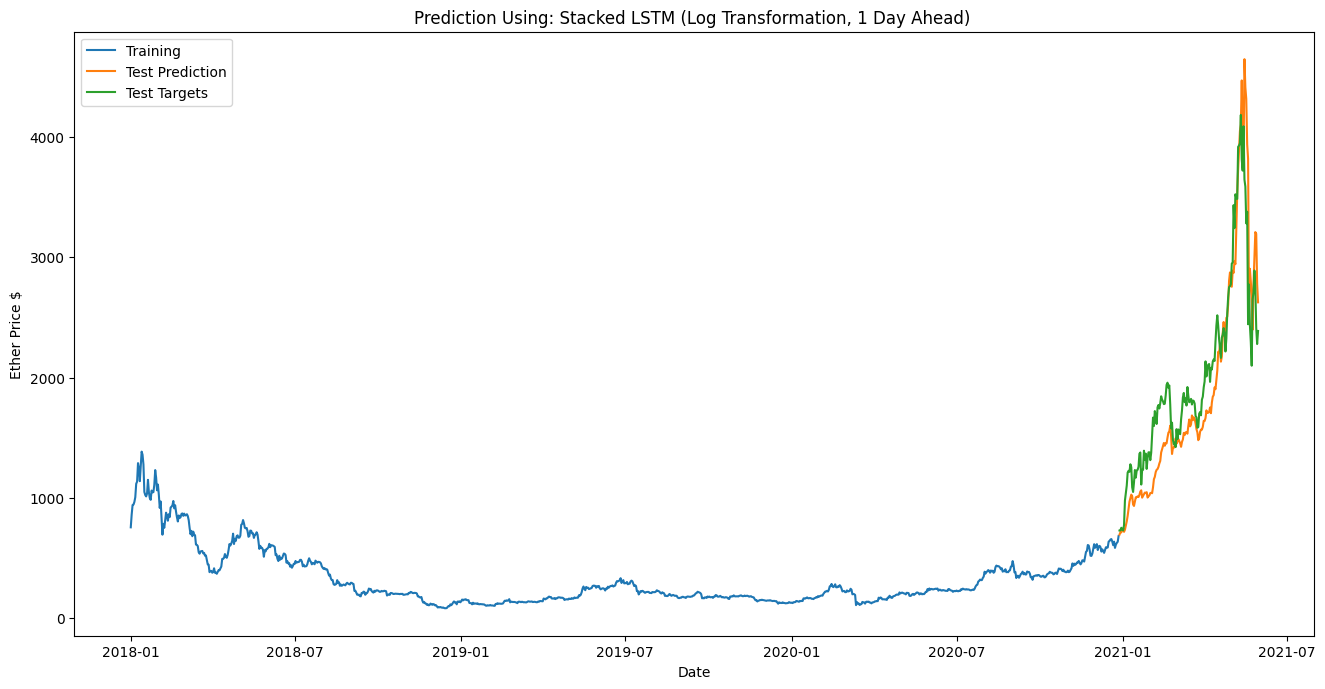

Total RMSE is:  343.48898307949275
Total APE is:  14.40596828059569
Runtime of the program is 60.14877963066101


In [15]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

n_features = train_x.shape[2]

# separate input data
#X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
#Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input,
n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_x, train_y, epochs=200, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_input, n_features))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='LSTM')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Stacked LSTM (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# Bidirectional LSTM with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.038] 0.0


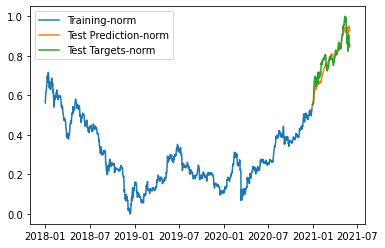

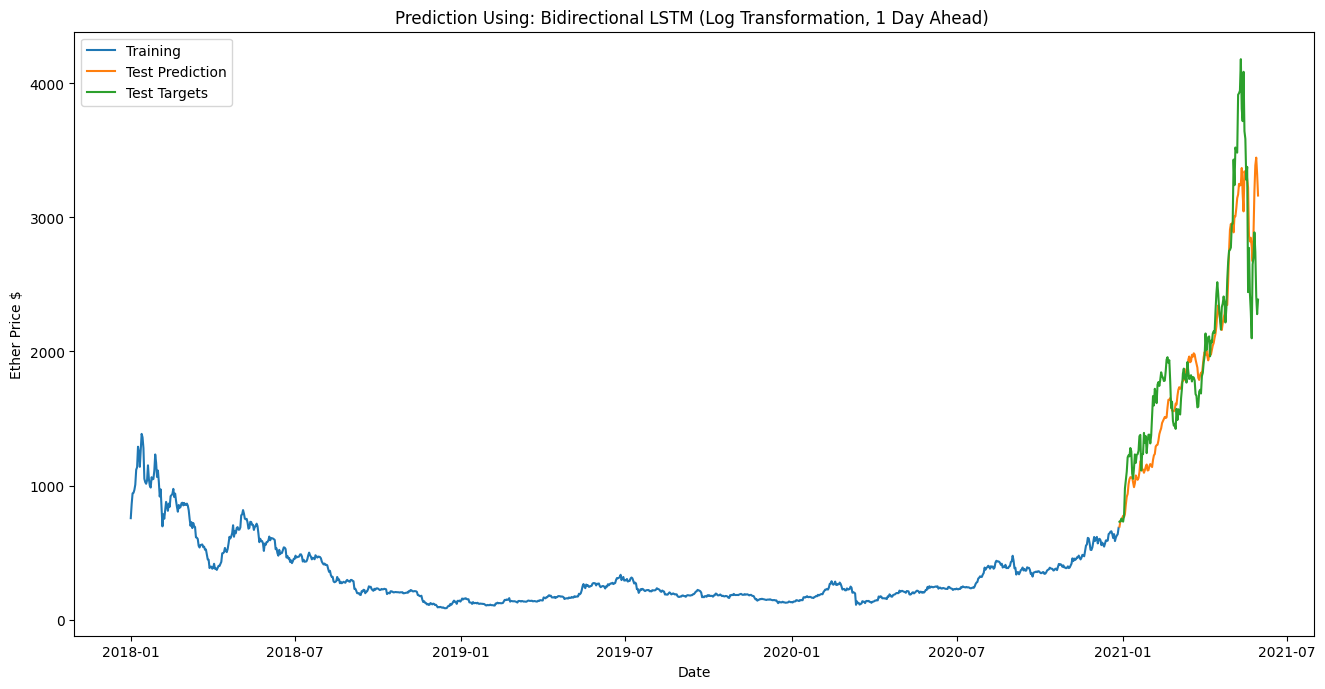

Total RMSE is:  312.70121692157636
Total APE is:  11.446597943246495
Runtime of the program is 40.51738381385803


In [23]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

n_features = train_x.shape[2]

# separate input data
#X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
#Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# define model
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_input, n_features)))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_x, train_y, epochs=200, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_input, n_features))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='LSTM')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Bidirectional LSTM (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# CNN-LSTM with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.064] 0.1


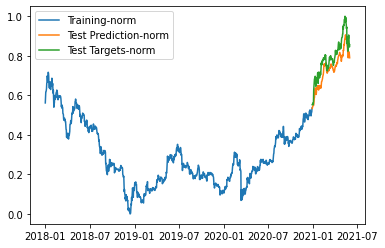

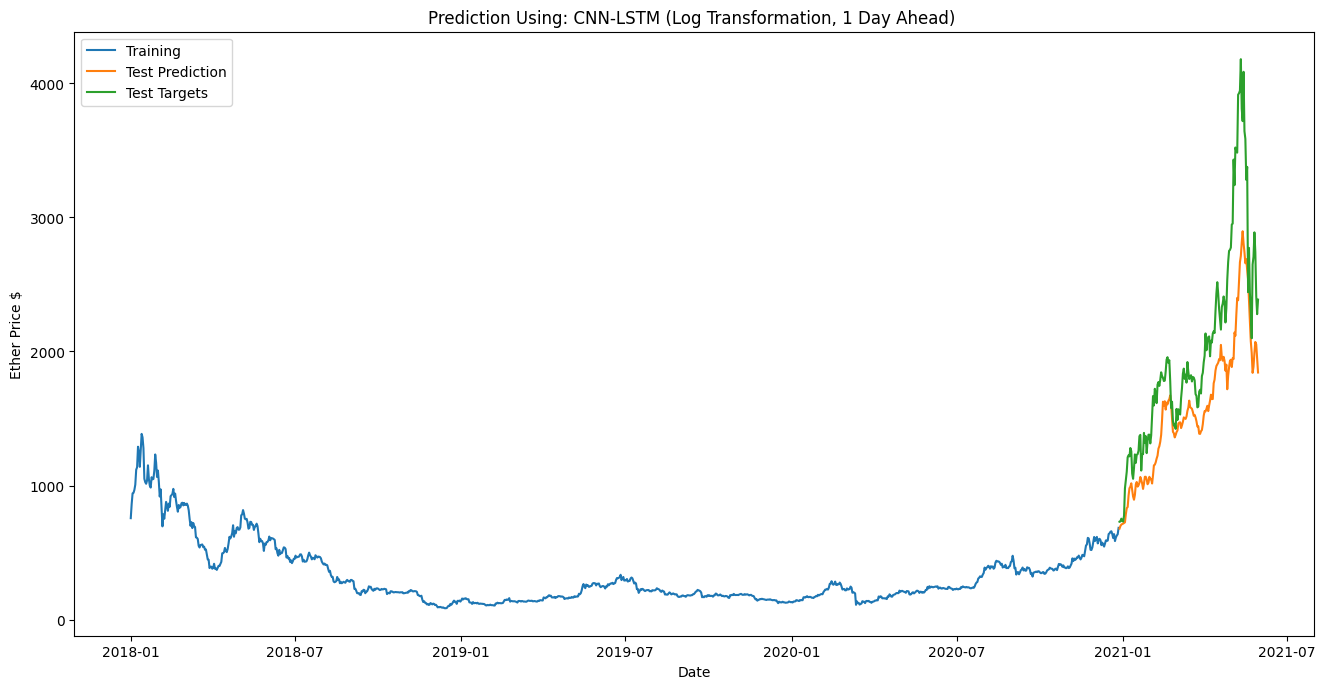

Total RMSE is:  533.314709066645
Total APE is:  19.393369971147287
Runtime of the program is 28.01224398612976


In [32]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = train_x.shape[2]
n_seq = 7
n_steps = int(n_input/n_seq)
train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, n_features))


# separate input data
#X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
#Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_x, train_y, epochs=200, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_seq, n_steps, n_features))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='LSTM')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: CNN-LSTM (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# ConvLSTM with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.069] 0.1


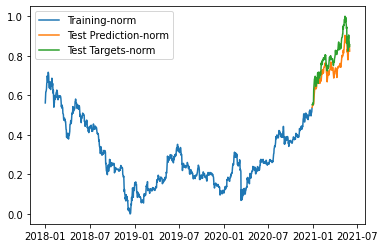

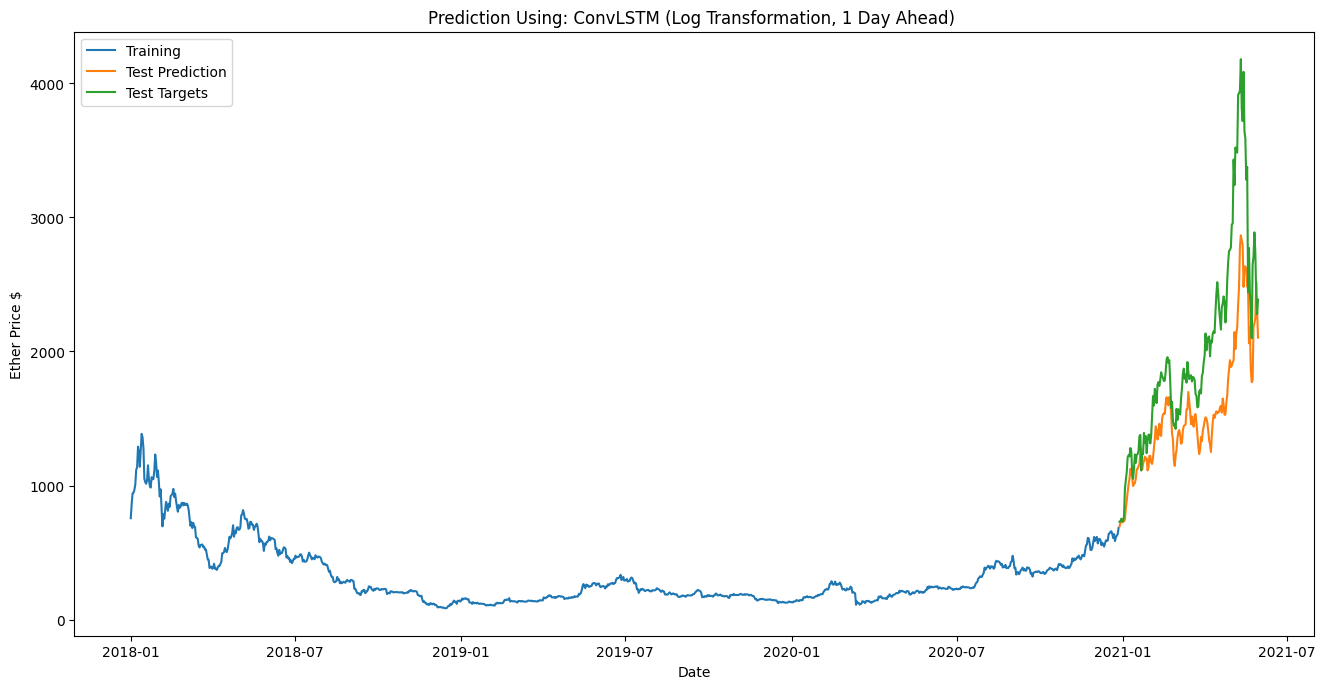

Total RMSE is:  584.8126395140199
Total APE is:  20.27879398846376
Runtime of the program is 44.881898403167725


In [40]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = train_x.shape[2]
n_seq = 2
n_steps = int(n_input/n_seq)
train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, n_features))


# separate input data
#X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
#Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,
1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_x, train_y, epochs=200, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_seq, 1, n_steps, n_features))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='LSTM')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: ConvLSTM (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# Encoder-Decoder LSTM with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.032] 0.0


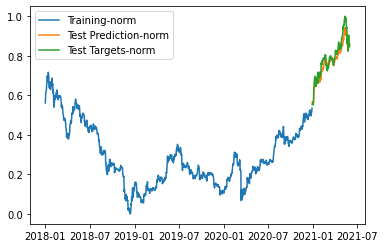

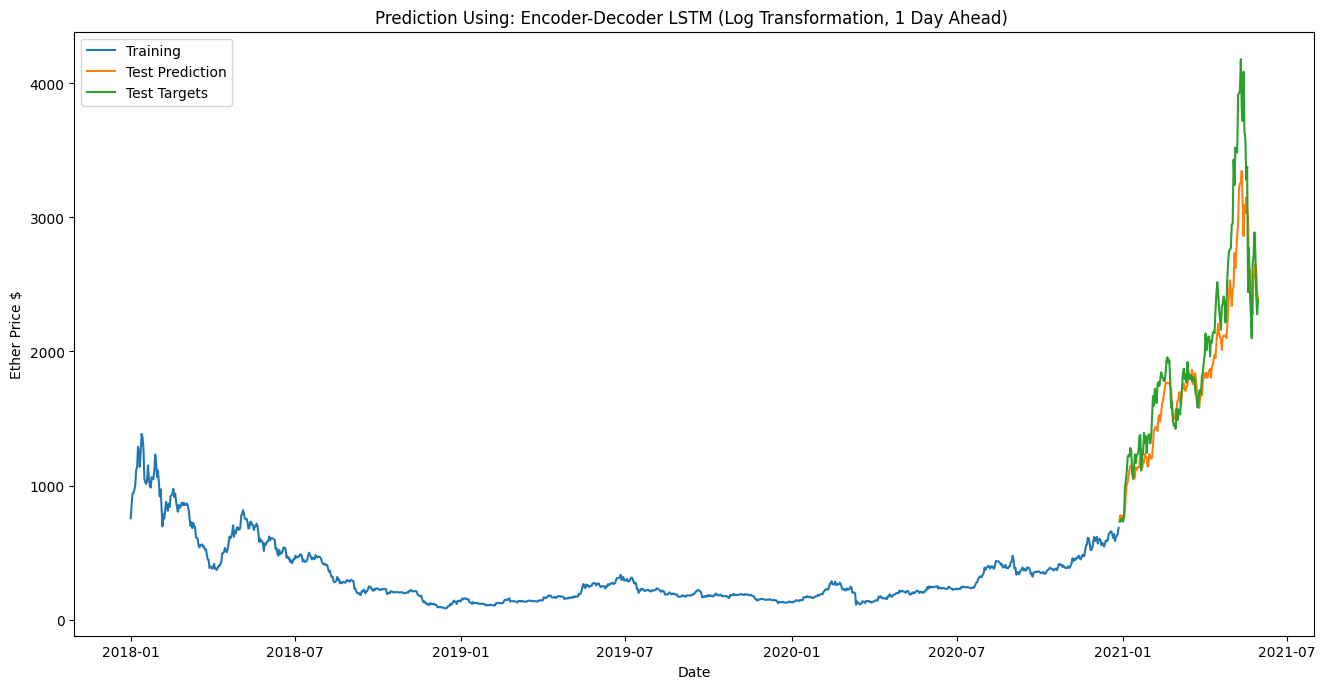

Total RMSE is:  299.5142802259264
Total APE is:  9.626378146888113
Runtime of the program is 51.385130643844604


In [48]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = train_x.shape[2]

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))


# separate input data
#X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
#Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(RepeatVector(n_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_x, train_y, epochs=200, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_input, n_features))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='LSTM')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Encoder-Decoder LSTM (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

In [22]:
train_y.shape

(1072, 7)